# Introduction

While browsing Kaggle, we found a dataset containing information on a wide variety of songs available on Spotify. Since Spotify is a major service and has a very wide array of licenses, we considered that this dataset might be a good candidate to test general hypotheses about tracks.

This dataset contains not just data about the track metadata and popularity but also contains some features extracted from the music itself, such as acousticness, energy and danceability. We don't currently have knowledge as to how exactly Spotify generated these features, but we believe at the outset that these values may contain enough information to make meaningful predictions about the track. In principle, if Spotify's methods for generating/detecting these values were well-known, we could extend this model to make predictions for any new track. First we would run the feature extraction method on the song, and then we would run the models we explore here against those features.

Our first idea was to use these features to predict the popularity of a song. Such a model might be useful for marketing purposes (where should marketing funds be placed for optimal benefit?) or for a record label to identify promising artists in a data-driven way.

However, this dataset also contains a "genre" column featuring over 100 unique genres. Given the richness of the categorical data here, we thought it would be interesting (if perhaps difficult) to try predicting a song's genre given its features. Genre is a fairly subjective categorization, and many genres blend together in some respects, so we expect this task to be challenging but possible. This type of prediction may also be valuable in marketing or in recommendation systems based on a user's previous musical interests.

For instance, a user who repeatedly likes songs in one genre which also have strong predictive elements of another genre might benefit from being recommended songs in that second genre. We might use the highest-probability prediction as the canonical genre label (at least until a genre expert weighs in), but also keep track of the 2nd and 3rd highest-probability genre predictions for the purpose of exploratory recommendations.

This problem seemed very interesting, so we decided to focus on **genre prediction using the provided track features**.

We are using the following dataset:

https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

It is also publicly accessible from Alex's Google Drive at the following link:
https://drive.google.com/uc?export=download&id=160yWJMowrf_Gmzj7m2MexDCJ8rhJPOBt

In addition, we have created a "Jukebox and Visualizer" app which allows users to randomly receive a listed track and listen to it via an embedded Spotify player. Users can re-roll their song at any time, and can also interactively plot the musical features of their choice from the dataset against one another (even visualizing where the current track lies with respect to the chosen features). The app is available at https://cis5450-getkahuangvitale.streamlit.app/

# Installations and Imports

In [ ]:
!pip install -U scikit-learn
!pip install sqlalchemy==1.4.46
!pip install pandasql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=22e2185b9a20879e06fbd40a2ab8531e20c62b304406cd4eccf63d759befba1f
  Stored in directory: /ro

In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
random_seed = 24

np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Data Fetching


In [ ]:
if not os.path.exists("spotify-dataset.csv"):
    !gdown --id 160yWJMowrf_Gmzj7m2MexDCJ8rhJPOBt

df_spotify = pd.read_csv("spotify-dataset.csv")

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=160yWJMowrf_Gmzj7m2MexDCJ8rhJPOBt
To: /content/spotify-dataset.csv
100% 20.1M/20.1M [00:00<00:00, 65.5MB/s]


In [ ]:
df_spotify = pd.read_csv("spotify-dataset.csv")
df_spotify.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Apparently the first column is a duplicate of the index which came directly from the `.csv` file. We can drop this column and stick with the index of the dataframe:

In [ ]:
df_spotify = df_spotify.drop(df_spotify.columns[0], axis=1)
df_spotify.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Exploratory Data Analysis

## Overview of dataset

First, using `.info()`, we can find general information regarding columns, their types, and the amount of nulls in each column:

In [ ]:
df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

The column `duration_ms` represents the duration of the song in milliseconds. To get a better intuition of it we can convert the values to minutes:

In [ ]:
df_spotify['duration_ms'] = df_spotify['duration_ms']/(1000*60)
df_spotify = df_spotify.rename({'duration_ms':'duration'}, axis=1)

Lastly, it is also helpful to find the number of unique values in each of the columns:

In [ ]:
df_spotify.nunique()

track_id            89741
artists             31437
album_name          46589
track_name          73608
popularity            101
duration            50697
explicit                2
danceability         1174
energy               2083
key                    12
loudness            19480
mode                    2
speechiness          1489
acousticness         5061
instrumentalness     5346
liveness             1722
valence              1790
tempo               45653
time_signature          5
track_genre           114
dtype: int64

Notice the column `mode` has only two values: a major key is represented by 1, and a minor key is represented by 0. In this case it would be more informative to rename the column to `is_major`:

In [ ]:
df_spotify = df_spotify.rename({'mode':'is_major'}, axis=1)

### Dropping null values

We can also find the rows which contain null values:

In [ ]:
rows_with_null = df_spotify[df_spotify.isnull().any(axis=1)]
rows_with_null

,track_id,artists,album_name,track_name,popularity,duration,explicit,danceability,energy,key,loudness,is_major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0.0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


Since this entry has the genre "k_pop", it is possible that there is simply an encoding issue which caused the null values to appear. The duration for this is track 0 milliseconds, which also does not make sense for a song.

With this, we can simply drop this row from the dataframe using SQL:

In [ ]:
rows_with_null_query = """
SELECT *
FROM df_spotify
WHERE track_name IS NULL
"""

rows_with_null = ps.sqldf(rows_with_null_query, locals())
rows_with_null

,track_id,artists,album_name,track_name,popularity,duration,explicit,danceability,energy,key,loudness,is_major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,1kR4gIb7nGxHPI3D2ifs59,None,None,None,0,0.0,0,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


In [ ]:
drop_null_query = """
SELECT *
FROM df_spotify
WHERE track_name IS NOT NULL
"""

df_spotify = ps.sqldf(drop_null_query, locals())

Now to double check all columns are non-null, we can use the `.info()` again:

In [ ]:
df_spotify = df_spotify.reset_index(drop=True)
df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113999 entries, 0 to 113998
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113999 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        113999 non-null  int64  
 5   duration          113999 non-null  float64
 6   explicit          113999 non-null  int64  
 7   danceability      113999 non-null  float64
 8   energy            113999 non-null  float64
 9   key               113999 non-null  int64  
 10  loudness          113999 non-null  float64
 11  is_major          113999 non-null  int64  
 12  speechiness       113999 non-null  float64
 13  acousticness      113999 non-null  float64
 14  instrumentalness  113999 non-null  float64
 15  liveness          113999 non-null  float64
 16  valence           11

## Feature Exploration

### Numerical Features

First, we can use `.describe()` to generate the descriptive statistics for the numerical columns and get an idea of mean/range/variance of each of the features in the dataframe:

In [ ]:
numerical_features = [
    'popularity','duration','loudness','danceability','energy','speechiness',
    'acousticness','instrumentalness','liveness','valence','tempo']

df_spotify[numerical_features].describe()

,popularity,duration,loudness,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,33.238827,3.800519,-8.258950,0.566801,0.641383,0.084652,0.314907,0.156051,0.213554,0.474066,122.147695
std,22.304959,1.788268,5.029357,0.173543,0.251530,0.105733,0.332522,0.309556,0.190378,0.259261,29.978290
min,0.000000,0.143100,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,2.901100,-10.013000,0.456000,0.472000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218500
50%,35.000000,3.548433,-7.004000,0.580000,0.685000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000
75%,50.000000,4.358433,-5.003000,0.695000,0.854000,0.084500,0.597500,0.049000,0.273000,0.683000,140.071000
max,100.000000,87.288250,4.532000,0.985000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


It can be seen that most of the columns have already been standardised to a range of 0 (least dancable, least energy etc.) to 1 (most dancable, most energy etc.). The few numerical columns that are not standardised are `popularity`, `duration`, `loudness` and `tempo`, all having physical meanings behind them.

We can select all the numerical features and examine their distributions:

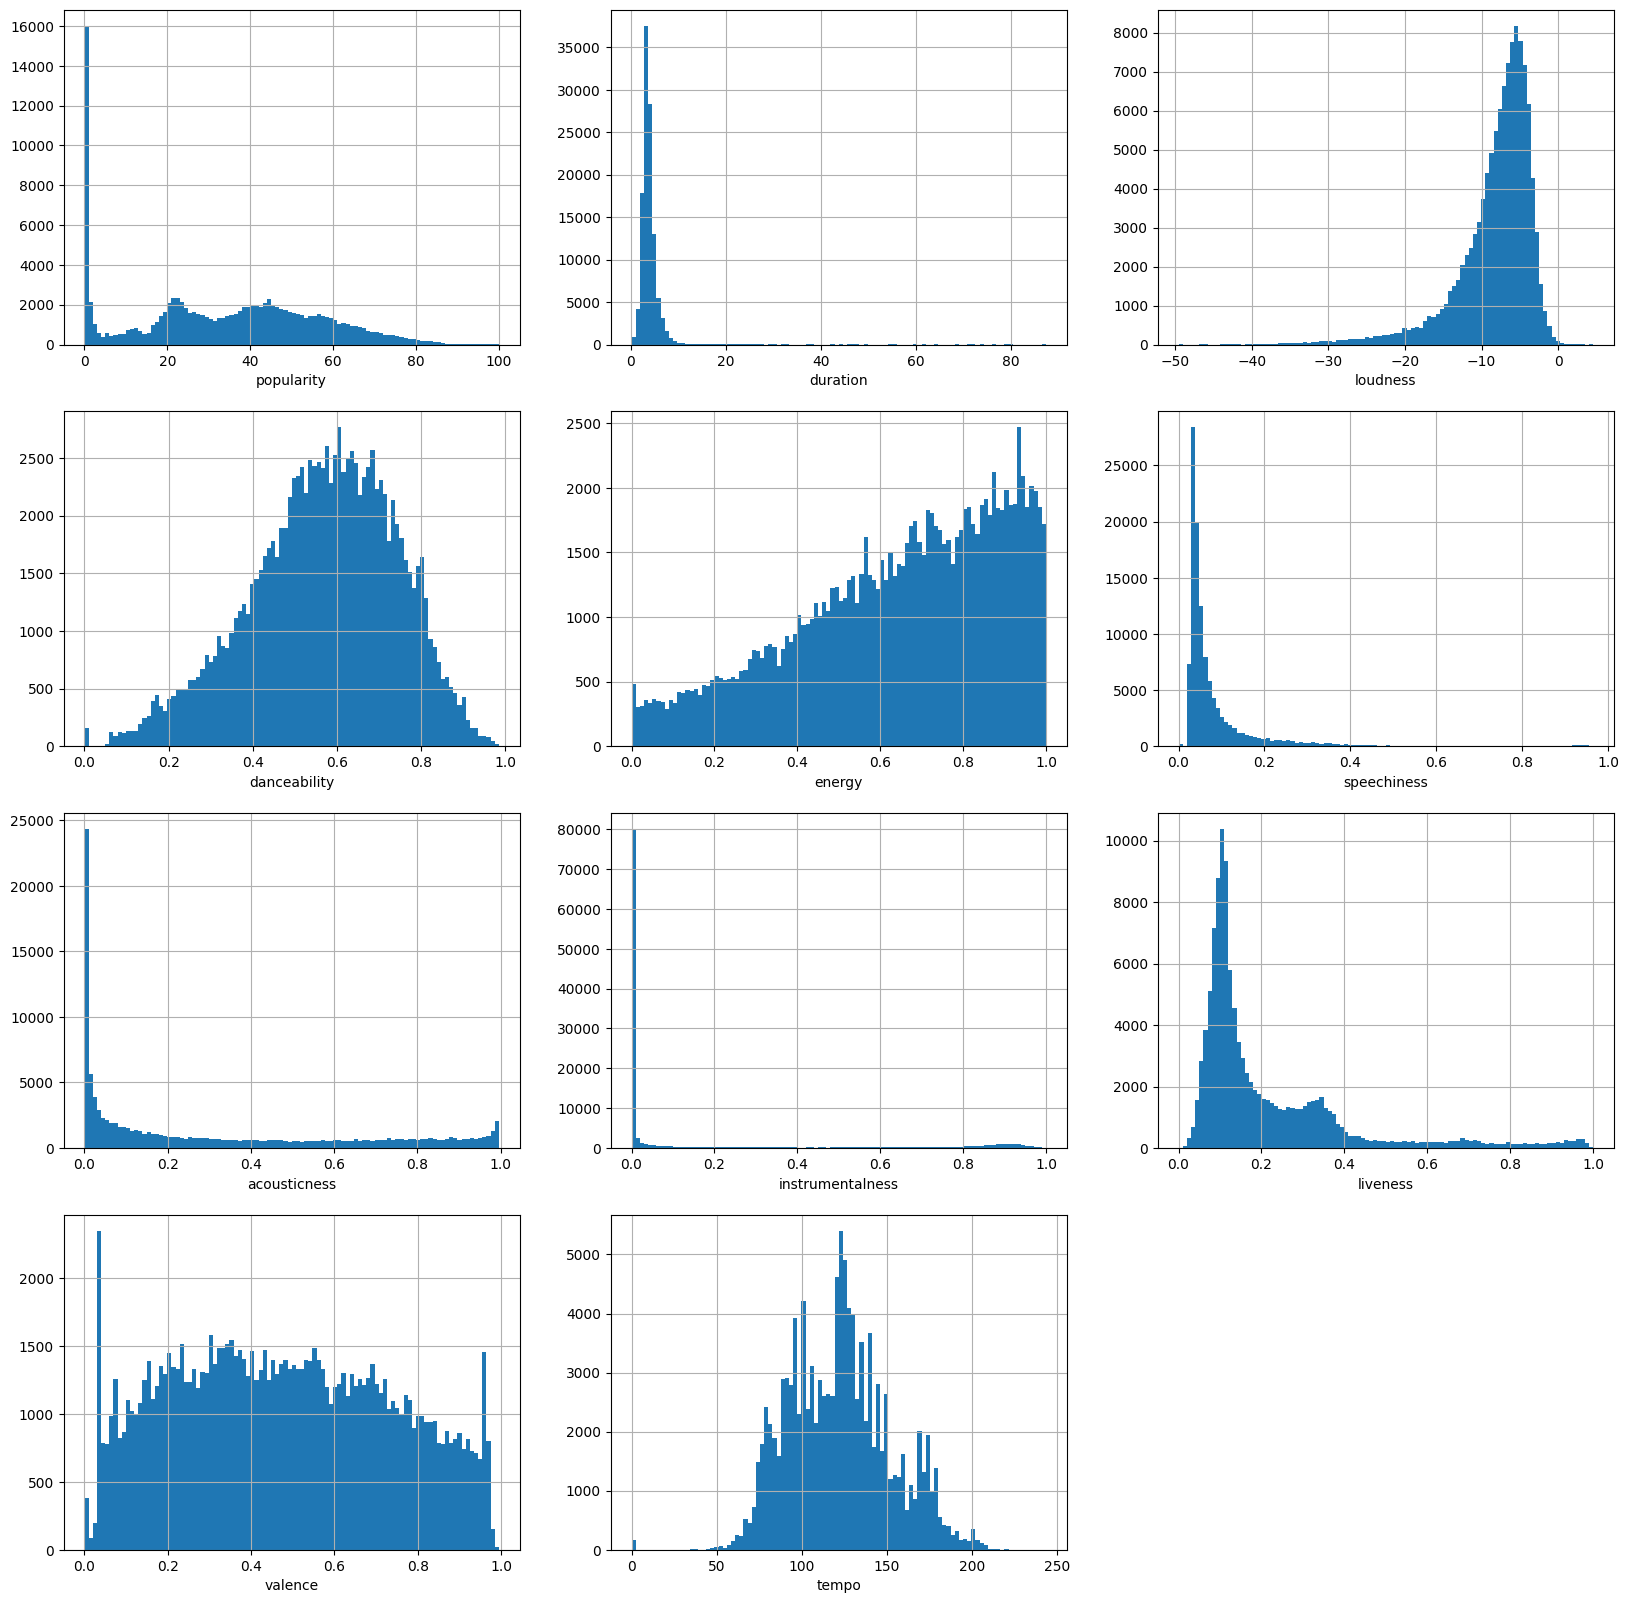

In [ ]:
plt.figure(figsize=(20,20))
n = 1
for i, feature in enumerate(numerical_features):
    plt.subplot(4,3,n)
    df_spotify[feature].hist(bins=100)
    plt.xlabel(feature)
    n += 1

We can see that the variables have very different distributions. Most features have a skewed distribution with a long tail, such as `liveness`, `speechiness` and `duration`. However, features such as `valence`, `tempo` and `danceability` have a more centered distribution.
`popularity` is another variable that has a long tail distribution. This reflects the real situation of music industry as a long tail market: there is a massive the pool of artists, yet very few of them can really become successful and popular. As a result, the tracks being listened to are mostly popular songs by popular artists with a high explosure to the public, resulting a very unbalanced distribution of popularity.

Most features also have a very concentrated distribution with a small standard deviation, with `energy` and `valence` being the only two features with a distribution spanning the entire range.


We can also construct a correlation heatmap to visualise the correlation between different features:

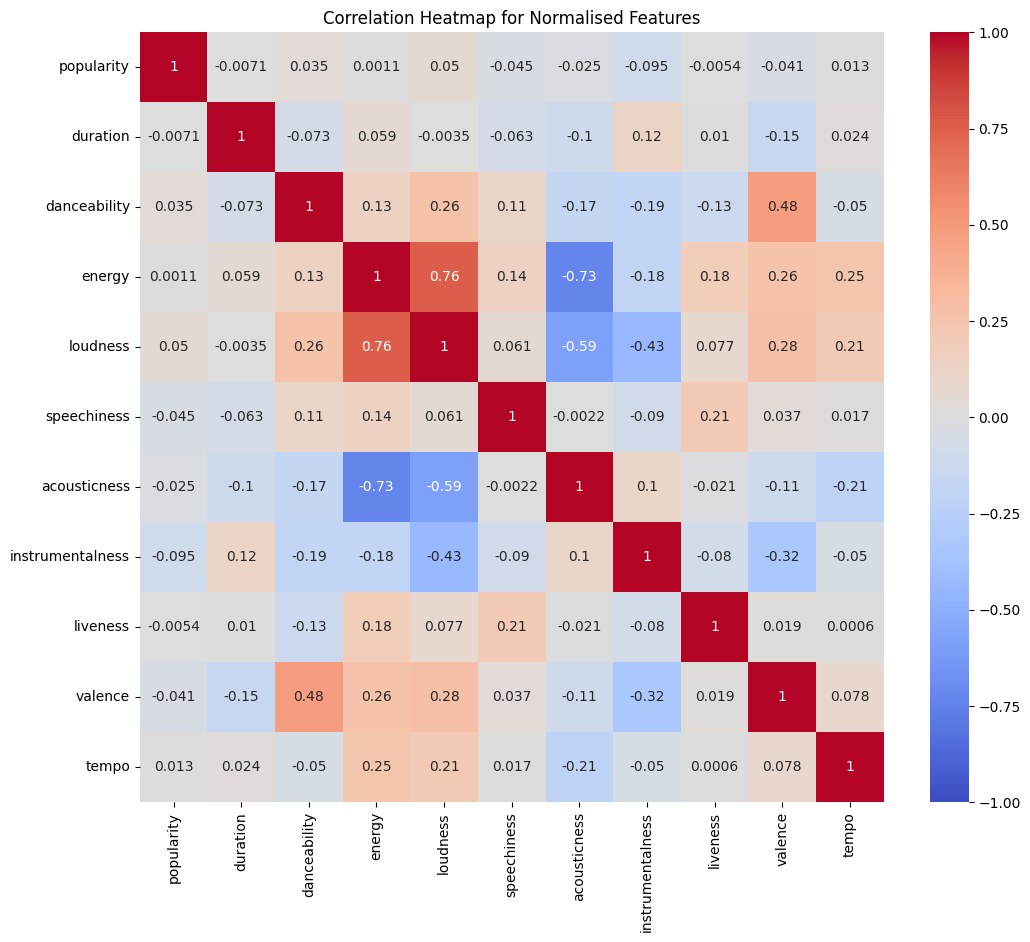

In [ ]:
correlation_matrix = df_spotify[numerical_features].corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Normalised Features')
plt.show()

We find that many features are highly correlated with each other (e.g. `loudness` and `energy`, `acousticness` and `energy`). This means we may need to use tools such as Principle Component Analysis (PCA) to remove the multicollinearity in the dataset.

### Categorical Features

We can select all the categorical data and change their dtype to object for future encoding:

In [ ]:
categorical_features = ['track_genre','key','time_signature','is_major']
for colname in categorical_features:
    df_spotify[colname].astype(object)

For each of the features, we can examine the distribution of its values:

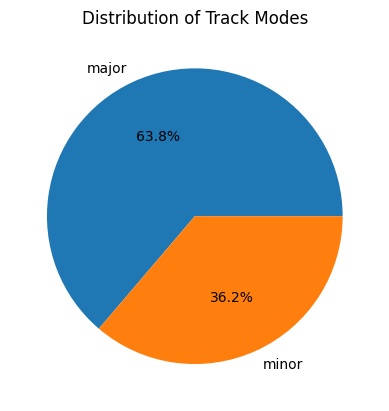

In [ ]:
plt.pie(df_spotify['is_major'].value_counts(), labels=['major','minor'], autopct='%1.1f%%')
plt.title("Distribution of Track Modes")
plt.show()

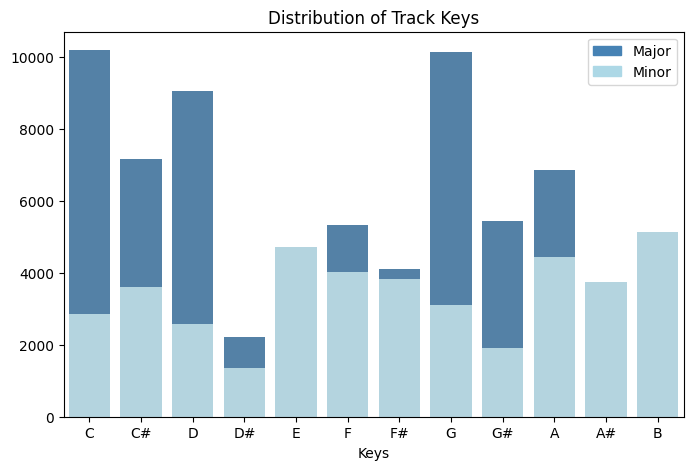

In [ ]:
# Map the encodings back to letter keys, then split by major and minor
key_list = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
keys_count = df_spotify['key'].value_counts().sort_index().values
major_count = df_spotify[['key','is_major']].groupby(by='key').sum().values.flatten()

# Bar plot
plt.figure(figsize=(8,5))
bar1 = sns.barplot(x=key_list, y=major_count, color='steelblue')
bar2 = sns.barplot(x=key_list, y=keys_count-major_count, color='lightblue')

top_bar = mpatches.Patch(color='steelblue', label='Major') # stack bars together
bottom_bar = mpatches.Patch(color='lightblue', label='Minor')
plt.legend(handles=[top_bar, bottom_bar])
plt.xlabel("Keys")
plt.title("Distribution of Track Keys")
plt.show()

From the distributions, we can see that most of the tracks are in a major mode, in a relatively simple key (generally, keys with fewer accidentals are easier to learn play on instruments) such as G and C major and E and B minor.

In [ ]:
time_signatures = df_spotify['time_signature'].value_counts().sort_index()
print('Counts of time signature:')
print(time_signatures)

Counts of time signature:
0       163
1       973
3      9195
4    101842
5      1826
Name: time_signature, dtype: int64


We can see that the most common by far is a 4/4 time signature, which is indeed the most popular time signature in all kinds of music with a steady and stable rhythm.

However, there is an issue with the time signatures data -- musically, it is meaningless to have a time signature of 0 or 1. These value probably came from errors in the detection of the time signature. As a result, a nearest neighbour imputation is completed on the invalid values, and a column is added to indicate if the time signature is imputed this way:

In [ ]:
df_spotify['time_signature'] = df_spotify['time_signature'].replace([0,1], np.nan)
df_spotify['time_signature_imputed'] = df_spotify['time_signature'].isna()

In [ ]:
# Keep only the feature columns, and convert columns with type bool to int to work with KNNImputer
df_impute = df_spotify.iloc[:,5:].drop('track_genre', axis=1)
df_impute[['explicit','is_major']] = df_impute[['explicit','is_major']].astype(int)

# Impute values
imputer = KNNImputer()
df_processed = pd.DataFrame(imputer.fit_transform(df_impute.to_numpy()),columns = df_impute.columns)
df_processed['time_signature'] = df_processed['time_signature'].astype(int)

In [ ]:
df_spotify['time_signature'].update(df_processed['time_signature'])
df_spotify['time_signature'] = df_spotify['time_signature'].astype(object)

# Confirm the counts of time signatures after imputation:
time_signatures = df_spotify['time_signature'].value_counts().sort_index()
print('Counts of time signature after imputation:')
print(time_signatures)

Counts of time signature after imputation:
3.0      9742
4.0    102431
5.0      1826
Name: time_signature, dtype: int64


### Genre Mapping

As it stands, we have over 100 genre categories, which is quite a few. Certainly there are many classification problems with just as many (or more) classses. However, musical genres are somewhat subjective and overlapping. Hence, there is value not only in predicting an exact subgenre (or subgenres), but also in predicting the coarser-grained notion of an overarching genre.

Using the knowledge of our team's musical experts (Edy and Joey), we create and apply a mapping from these finer-grained exact subgenres to their looser overarching genres. Then we can predict these coarse genres instead of (or potentially in addition to) the relevant subgenres.

We intuit that by reducing the number of output classes, the difficulty of the classification problem will be reduced, and the outputs will be easier to parse, while retaining a large portion of the business value of the predictor.

Of course, the exact nature of this mapping is subjective, but the pipeline of our analysis is robust to changes in this mapping. Consequently, we expect that this mapping could be freely updated, and as long as it produces a set of genre classes, a simple re-run of our analysis/notebook would work.

In [ ]:
df_spotify['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [ ]:
genres_mapping = {
    "rock": ['alt-rock', 'alternative', 'emo', 'grunge', 'hard-rock', 'indie',
             'psych-rock', 'punk-rock', 'punk', 'rock-n-roll', 'rock', 'rockabilly'],
    "jazz-blues": ['bluegrass', 'blues', 'country', 'folk', 'gospel', 'honky-tonk',
                   'guitar', 'reggae', 'reggaeton', 'soul', 'jazz'],
    "groovy": ['afrobeat', 'dance', 'dancehall', 'disco', 'funk', 'groove',
               'party', 'r-n-b', 'hip-hop', 'trip-hop'],
    "pop": ['british', 'french', 'german', 'indie-pop', 'pop-film', 'pop',
            'power-pop', 'show-tunes', 'singer-songwriter',
            'songwriter', 'spanish', 'swedish', 'synth-pop'],
    "asian": ['anime', 'cantopop', 'j-dance', 'j-idol', 'j-pop', 'j-rock',
              'k-pop', 'malay', 'mandopop'],
    "latin": ['brazil', 'forro', 'latin', 'latino', 'mpb', 'pagode', 'salsa',
              'samba', 'sertanejo', 'ska', 'tango'],
    "metal": ['black-metal', 'death-metal', 'goth', 'grindcore', 'hardcore', 'hardstyle',
              'heavy-metal', 'metal', 'metalcore'],
    "electronic": ['club', 'deep-house', 'drum-and-bass', 'dub', 'dubstep', 'edm',
                   'electro', 'electronic', 'garage', 'house',  'trance'],
    "techno": ['breakbeat', 'chicago-house', 'detroit-techno', 'idm', 'industrial',
               'minimal-techno', 'progressive-house', 'techno'],
    "ambient-classical": ['ambient', 'chill', 'new-age', 'sleep', 'study',
                          'acoustic', 'classical', 'opera', 'piano'],
    "misc": ['indian', 'iranian', 'turkish', 'world-music', 'children', 'comedy',
             'disney', 'kids', 'romance', 'happy', 'sad']
}

In [ ]:
# This function takes a subgenre, a "finer genre" and returns the corresponding "coarse" genre.
def subgenre_to_coarse(genre):
    result = '' # default case if nothing is found
    for coarse_genre, subgenres in genres_mapping.items():
        if genre in subgenres:
            result = coarse_genre
            break
    return result

In [ ]:
df_spotify_coarse = df_spotify.copy()
df_spotify_coarse['track_genre_coarse'] = df_spotify_coarse['track_genre'].apply(subgenre_to_coarse)

And now, since some songs with multiple subgenres may belong to the same loose genre, we must drop duplicates:

In [ ]:
df_spotify_coarse = df_spotify_coarse.drop('track_genre', axis=1).drop_duplicates().reset_index(drop=True)
df_spotify_coarse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102545 entries, 0 to 102544
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   track_id                102545 non-null  object 
 1   artists                 102545 non-null  object 
 2   album_name              102545 non-null  object 
 3   track_name              102545 non-null  object 
 4   popularity              102545 non-null  int64  
 5   duration                102545 non-null  float64
 6   explicit                102545 non-null  int64  
 7   danceability            102545 non-null  float64
 8   energy                  102545 non-null  float64
 9   key                     102545 non-null  int64  
 10  loudness                102545 non-null  float64
 11  is_major                102545 non-null  int64  
 12  speechiness             102545 non-null  float64
 13  acousticness            102545 non-null  float64
 14  instrumentalness    

Now, we can also left join back to the original `df_spotify` (with the mapped dataframe on the right due to dropping duplicates):

In [ ]:
df_spotify_full = df_spotify.merge(df_spotify_coarse, how='left', suffixes=('','_coarse'))

Now we have three different dataframes available: one with the coarse genre, one with the fine genre, and one with both. For subsequent modelling can use whichever dataframe we feel appropriate to use. In this analysis we will focus on the coarse genres, but as mentioned before, the general framework for this analysis would work regardless of how many and how specific the genres are.

With the coarse genres, we also need to confirm that the data points are evenly distributed across all the genres. We can confirm this by plotting the number of data points in each genre:

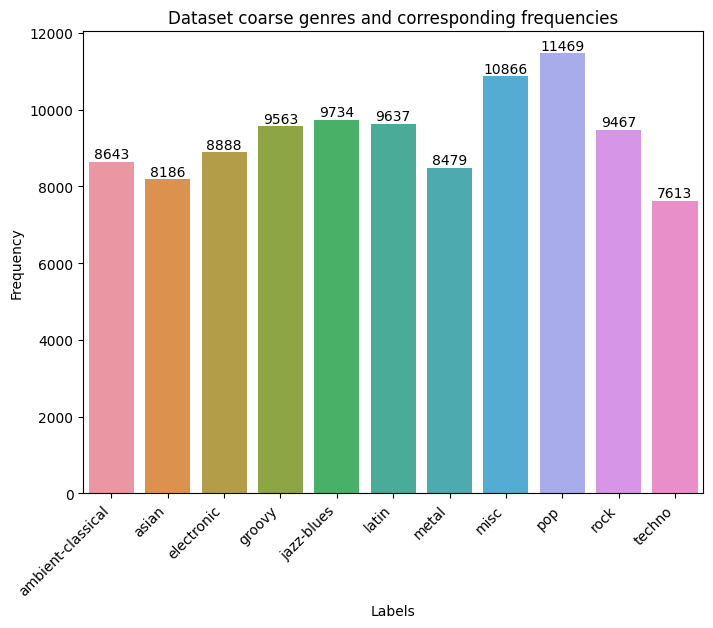

In [ ]:
# Get distribution of data points by coarse genre
genres_count = df_spotify_coarse[['track_genre_coarse', 'track_id']].groupby(by='track_genre_coarse').count().reset_index()

# Bar plot of results
fig = plt.figure(figsize=(8, 6))
sns.barplot(x=genres_count['track_genre_coarse'], y=genres_count['track_id'])
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Dataset coarse genres and corresponding frequencies")
plt.xticks(rotation=45, ha='right')
for idx, row in genres_count.iterrows():
    plt.text(idx, int(row['track_id'])+20, row['track_id'], ha='center', va='bottom')
plt.show()

Although the classes does not all have the same number of data points, this is still a fairly even split with most genres having around 9000 samples. This is also a reflection of the natural distribution of music genres -- some genres such as pop would naturally have more songs in the spotify music library, while the niche genres such as techno and metal would have less songs in the library.

## Genre vs Popularity

Another interesting comparison to make is to examine how popularity differs in each genre.

First, we can plot the average popularity for songs in each genre:

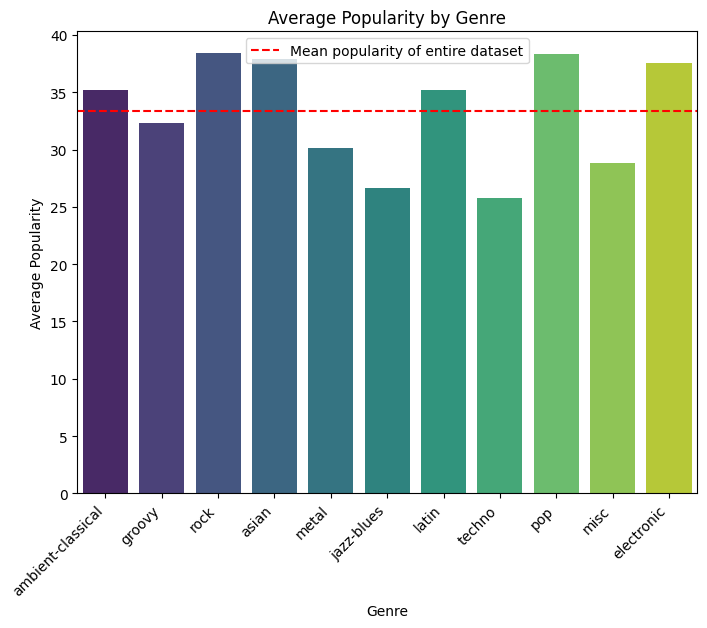

In [ ]:
# Bar plot of average popularity by genre
plt.figure(figsize=(8, 6))
sns.barplot(x="track_genre_coarse", y="popularity", data=df_spotify_coarse, errorbar=None, palette="viridis")
plt.title("Average Popularity by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Popularity")
plt.axhline(df_spotify_coarse['popularity'].mean(), color='red', linestyle='--')
plt.legend(['Mean popularity of entire dataset'])
plt.xticks(rotation=45, ha="right")
plt.show()

From the graph, we can see that some of the more mainstream genres, such as pop and rock, do indeed have a higher popularity; while some of the niche genres, such as techno and metal, as well as 'old-school' genres such as jazz and blues, have a lower popularity. Asian is also a surprisingly popular genre, likely due to the influence of anime and k-pop as well as the large population base in east Asia.


We can also look at the popularity distribution within each genre:

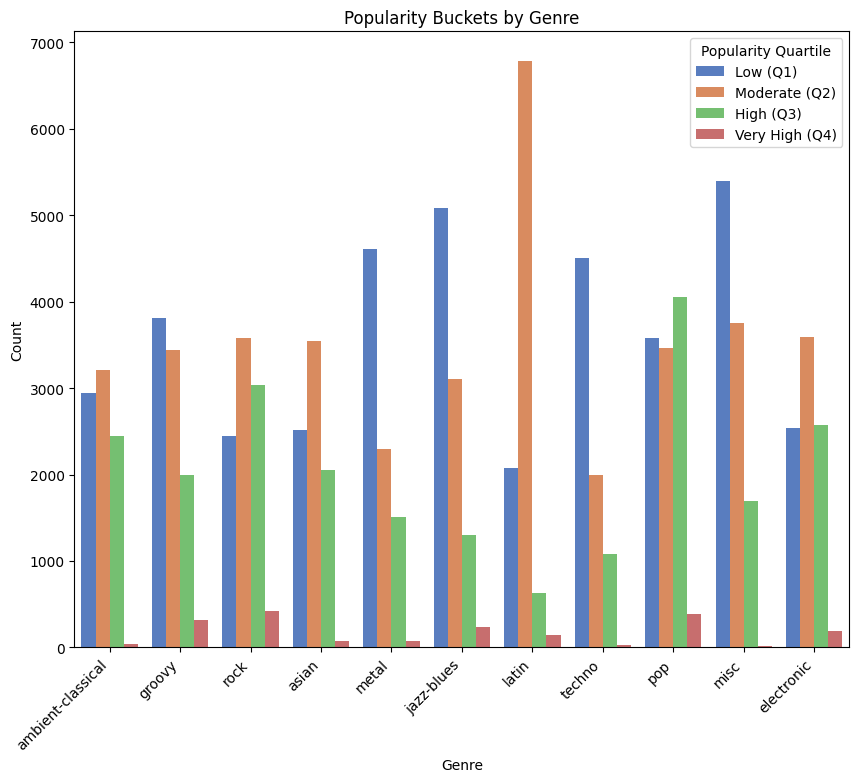

In [ ]:
# Create popularity buckets (adjust the bin edges based on our data distr.)
popularity_bins = [0, 25, 50, 75, 100]
popularity_labels = ['Low (Q1)', 'Moderate (Q2)', 'High (Q3)', 'Very High (Q4)']

df = df_spotify_coarse.copy()
df['popularity_bucket'] = pd.cut(df['popularity'], bins=popularity_bins, labels=popularity_labels, include_lowest=True)

# Bar plot of popularity buckets by genre
plt.figure(figsize=(10, 8))
sns.countplot(x="track_genre_coarse", hue="popularity_bucket", data=df, palette="muted")
plt.title("Popularity Buckets by Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Popularity Quartile")
plt.show()

As expected, in genres with a higher average popularity (such as pop and rock), songs also tend to be at a higher popularity. The opposite is also true for the niche genres such as metal and techno.

# Data Preprocessing



## Feature Normalisation

Most of the numerical columns are in a range of 0 to 1. In order to apply PCA, we need to normalise them to having zero mean and unit variance.

The columns `popularity`, `duration`, `loudness` and `tempo` have not been standardised at all. Since these columns have physical interpretations behind the values, we are going to create three new columns `relative_duration`, `relative_loudness` and `relative_speed` for the normalised values

In [ ]:
from sklearn.preprocessing import StandardScaler

df_spotify_normalised = df_spotify_coarse.copy()
sc = StandardScaler()
scaling_col = numerical_features
for i in scaling_col:
    df_spotify_normalised[i] = sc.fit_transform(df_spotify_normalised[[i]])

To confirm that the columns have been normalised correctly, we can use `.describe()` again:

In [ ]:
df_spotify_normalised[numerical_features].describe()

,popularity,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1.025450e+05,1.025450e+05,1.025450e+05,1.025450e+05,1.025450e+05,1.025450e+05,1.025450e+05,1.025450e+05,1.025450e+05,1.025450e+05,1.025450e+05
mean,1.563201e-16,-1.241692e-16,4.573194e-16,2.627508e-16,7.344827e-17,7.427976e-17,-1.773845e-17,8.425764e-17,-6.042160e-17,-1.374730e-16,3.835940e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.549106e+00,-2.010303e+00,-3.231609e+00,-2.513382e+00,-8.059329e+00,-7.871032e-01,-9.608744e-01,-5.192915e-01,-1.118454e+00,-1.811133e+00,-4.070042e+00
25%,-7.143052e-01,-5.036823e-01,-6.367288e-01,-6.827993e-01,-3.489081e-01,-4.582437e-01,-9.092009e-01,-5.192915e-01,-6.074245e-01,-8.326723e-01,-7.595979e-01
50%,2.774032e-02,-1.424252e-01,7.772054e-02,1.654234e-01,2.501688e-01,-3.400742e-01,-4.262180e-01,-5.191244e-01,-4.308302e-01,-4.222925e-02,-6.190183e-04
75%,7.697858e-01,3.148578e-01,7.350140e-01,8.479467e-01,6.474637e-01,-8.466589e-03,8.641260e-01,-2.990102e-01,3.140954e-01,8.096074e-01,6.011343e-01
max,3.088678e+00,4.577146e+01,2.398252e+00,1.431840e+00,2.531872e+00,8.052713e+00,2.014085e+00,2.645669e+00,4.090816e+00,2.006783e+00,4.047124e+00


## Encoding Categorical Features

### Encoding `track_genre`

First, we want to encode the `track_genre` labels from strings of genre names to integers.

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_spotify_encoded = df_spotify_normalised.copy()
le = LabelEncoder()
df_spotify_encoded['track_genre_coarse'] = le.fit_transform(df_spotify_encoded['track_genre_coarse'])
encoded_genre_labels = df_spotify_encoded['track_genre_coarse'].unique()
encoded_genre_labels

array([ 0,  3,  9,  1,  6,  4,  5, 10,  8,  7,  2])

In [ ]:
encoding = {i:cl for i,cl in enumerate(le.classes_)}
encoding

{0: 'ambient-classical',
 1: 'asian',
 2: 'electronic',
 3: 'groovy',
 4: 'jazz-blues',
 5: 'latin',
 6: 'metal',
 7: 'misc',
 8: 'pop',
 9: 'rock',
 10: 'techno'}

### Encoding `time_signature`

`time_signature` has three unique values: 3, 4 and 5. Having a low cardinality, we can use one-hot encoding on this feature:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
ohe = enc.fit_transform(df_spotify_encoded['time_signature'].to_numpy().reshape(-1, 1))
ohe = ohe.toarray()

In [ ]:
df_spotify_encoded[['3_meter','4_meter','5_meter']] = ohe
df_spotify_encoded = df_spotify_encoded.drop('time_signature', axis=1)

### Encoding `key`

`key` has 12 unique values ranging from 0 to 11. This has a high cardinality, so using one-hot encoding is not desirable as it increases the dimension of the input space dramatically.

An alternative scheme we can use here is *target encoding*, which encodes the feature using another target variable using the posterior probability of the target given particular categorical value and the prior probability of the target over all the training data. This has the benefit of being parameter free as well as resulting in no increase in feature space. The implementation in `scikit-learn` also uses regularisation to increase the performance and reduce target leaking.

In [ ]:
from sklearn.preprocessing import TargetEncoder

enc = TargetEncoder()
key_enc = enc.fit_transform(df_spotify_encoded['key'].to_numpy().reshape(-1,1),
                            df_spotify_encoded['popularity'].to_numpy())

# Rescale the encoded key value
sc = StandardScaler()
key_enc = sc.fit_transform(key_enc).flatten()
df_spotify_encoded['key'] = key_enc

## Principal Component Analysis

As we have observed during EDA, many of the features show correlation between them, so we utilise PCA to eliminate the collinearity as well as reduce dimensionality to improve model performance.

However, PCA only works with continuous numerical data. While the target encoded feature would be compatible, we have encoded `time_signature` using one-hot encoding, which still outputs a categorical feature, hence not compatible with PCA. In order to retain this feature, we can use [FAMD](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210), an generalised PCA algorithm, which accepts both numerical and categorical variables by pre-processing the categorical variables

In [ ]:
# FAMD preprocessing on categorical variables
time_signature_counts = df_spotify_encoded[['3_meter','4_meter','5_meter']].sum().to_numpy()
time_signature_probs = time_signature_counts/len(df_spotify_encoded)

df_spotify_encoded[['3_meter','4_meter','5_meter']] = df_spotify_encoded[['3_meter','4_meter','5_meter']]/np.sqrt(time_signature_probs)

In [ ]:
from sklearn.decomposition import PCA

X = df_spotify_encoded.iloc[:,4:].drop(['track_genre_coarse'], axis=1).to_numpy(dtype='float64')
pca = PCA()
X_pca = pca.fit_transform(X)

In order to assess the results of the PCA algorithm, we can calculate the cumulative explained variance ratios of each component. We can then the cumulative explained variance ratio against the number of components to decide the best number of components to keep.

Text(0.5, 1.0, 'Number of Components vs Explained Variance Ratio')

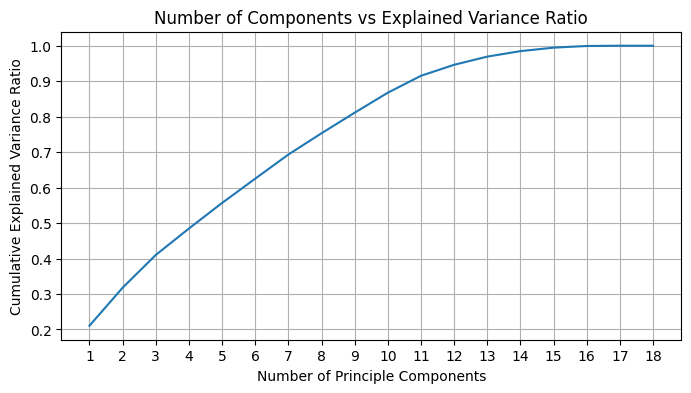

In [ ]:
ratios = pca.explained_variance_ratio_
variance = np.cumsum(ratios)

plt.figure(figsize=(8,4))
plt.plot(np.arange(1,19,1), variance)
plt.grid()
plt.xlabel('Number of Principle Components')
plt.xticks(np.arange(1,19,1))
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Number of Components vs Explained Variance Ratio')

From the graph, the number of components are selected to be 11, since this is the first point with over 0.9 cumulative explained variance ratio, and visually this is the knee of the plot.

In [ ]:
PCA_count = 11
pca = PCA(n_components=PCA_count)
X_pca = pca.fit_transform(X)

# Modeling + Analysis


First, we scale the data and perform a train-test split at 80-20 ratio using the `train_test_split` function in `scikit-learn`. We explicitly pass a `stratify` parameter to ensure that the splitted train and test set has the same distribution of target variables as the original dataset.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scaling using StandardScaler
sc = StandardScaler()
X_pca_scaled = sc.fit_transform(X_pca)

# Train test split
target = df_spotify_encoded['track_genre_coarse'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_pca_scaled, target, test_size=0.2, random_state=random_seed, stratify=target)

# Train test split on pre-PCA data
X_train_prePCA, X_test_prePCA, y_train_prePCA, y_test_prePCA = train_test_split(X, target, test_size=0.2, random_state=random_seed, stratify=target)

We have also created a function to plot the confusion matrix of models.

In [ ]:
def plot_confusion_matrix(cf_matrix):
    plt.figure(figsize=(8,6))
    group_names = list(encoding.values())
    sns.heatmap(cf_matrix, xticklabels=group_names, yticklabels=group_names, cmap='Blues')
    plt.xlabel('Predicted Genre')
    plt.ylabel('Actual Genre')
    plt.title('Confusion Matrix')

## Traditional Models

### Logistic Regression

First, we apply a logistic regression model as the baseline model. This model is a simple and interpretable algorithm, making it easy to understand and communicate the relationship between the track features and the genre probability. However, due to its simplicity it may not capture more complex, non linear relationships in the data.

For hyperparameter tuning on the model, since we require a multinomial classification, we are limited to the `'lbfgs'` solver, which can only take l2 regularisation. We experimented with different regularisation strengths as well as not having any regularisation. We also used the cross-validation parameter in `GridSearchCV` so we do not need to perform a separate training and validation split. After obtaining the best model, we fit it on the test set to get the train and test accuracies.

In [ ]:
# Define hyperparameter grid
param_grid = {
    'penalty': [None, 'l2'],
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5],
}

# Hyperparameter search
grid_search_logreg = GridSearchCV(estimator=LogisticRegression(multi_class='multinomial', random_state=random_seed),
                           param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

# Get model with best results
best_params_logreg = grid_search_logreg.best_params_
best_model_logreg = grid_search_logreg.best_estimator_
print(f"Best hyperparameters: {best_params_logreg}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best hyperparameters: {'C': 0.01, 'penalty': None}


Logistic regression: train accuracy: 0.3191; test accuracy: 0.3130


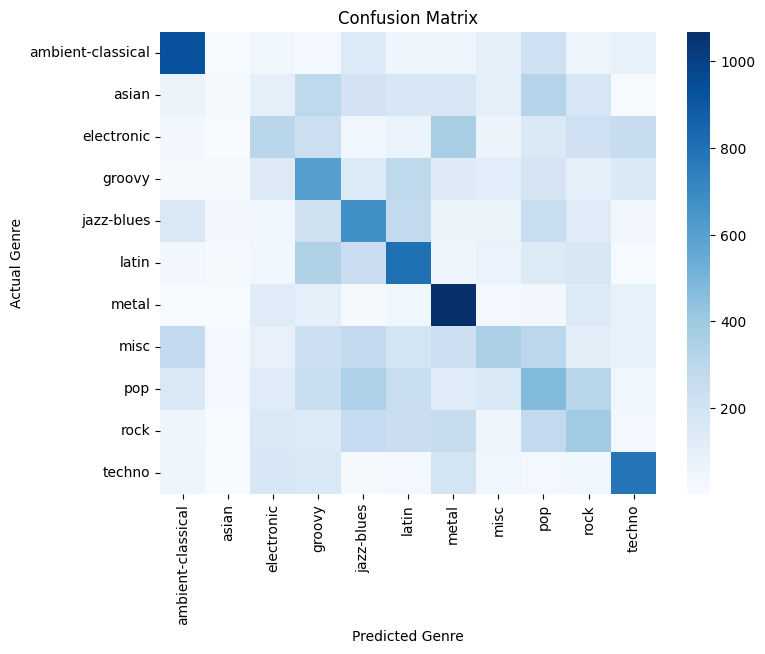

In [ ]:
# Use the best model to predict on the test set
y_pred = best_model_logreg.predict(X_test)

# Find the accuracies and confusion matrix
logreg_acc = best_model_logreg.score(X_test, y_test)
logreg_acc_train = best_model_logreg.score(X_train, y_train)
logreg_confusion = confusion_matrix(y_test, y_pred)

print(f"Logistic regression: train accuracy: {logreg_acc_train:.4f}; test accuracy: {logreg_acc:.4f}")
plot_confusion_matrix(logreg_confusion)

The model did not perform very well on the dataset, which is not unexpected as the relationship between the features and labels are indeed complex. The best hyperparameter selected is actually one without any regularisation, indicating that despite over 80,000 points of training data, the model is still underfitting due to the complexity of the relationship. The small difference between training (0.3191) and test accuracy (0.3130) also confirms this.

However, we can observe trends in the confusion matrix, where some genres are easier to classify than the rest. For example, metal, techno and classical are all categorised with a very high accuracy, which makes sense considering how these genres all have their unique sonic identities. However, for genres such as pop, rock, and asian, the model performed significantly worse.

### Random Forest

Next, we applied a random forest classifier, where multiple decision trees are aggregated, providing improved generalization and accuracy while still maintaining a reasonable level of interpretability. It can handle complex relationships and non-linearities in the data, which is beneficial for predicting music genres that often exhibit intricate patterns. The algorithm also provides feature importance scores, aiding in the identification of key predictors influencing genre classification. However, there are drawbacks to consider. Random Forest models can be computationally expensive, particularly with large datasets or numerous trees in the forest.

For hyperparameter tuning, we have selected three hyperparameters: `n_estimators` refers to the number of decision trees in the classifier, `max_depth` controls the maximum depth of the trees and `min_samples_split` controls the minimum number of samples required to split an internal node, influencing the tree's depth and complexity.

We have applied the random forest classifier to the data both before and after PCA. While PCA can reduce dimensionality to improve the computational performance, it increases the variance in the data and may impact the interpretability. For both models we have performed hyperparameter tuning as described above.

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [10, 30, 90],
    'max_depth': [10, 20, 50],
    'min_samples_split': [2, 5, 10]
}

# Hyperparameter search
grid_search_rf_prePCA = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=random_seed),
                             param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search_rf_prePCA.fit(X_train_prePCA, y_train_prePCA)

# Get model with best results
best_params_rf_prePCA = grid_search_rf_prePCA.best_params_
best_model_rf_prePCA = grid_search_rf_prePCA.best_estimator_
print(f"Best hyperparameters: {best_params_rf_prePCA}")

Best hyperparameters: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 90}


Pre PCA random forest: train accuracy: 0.9726; test accuracy: 0.4742


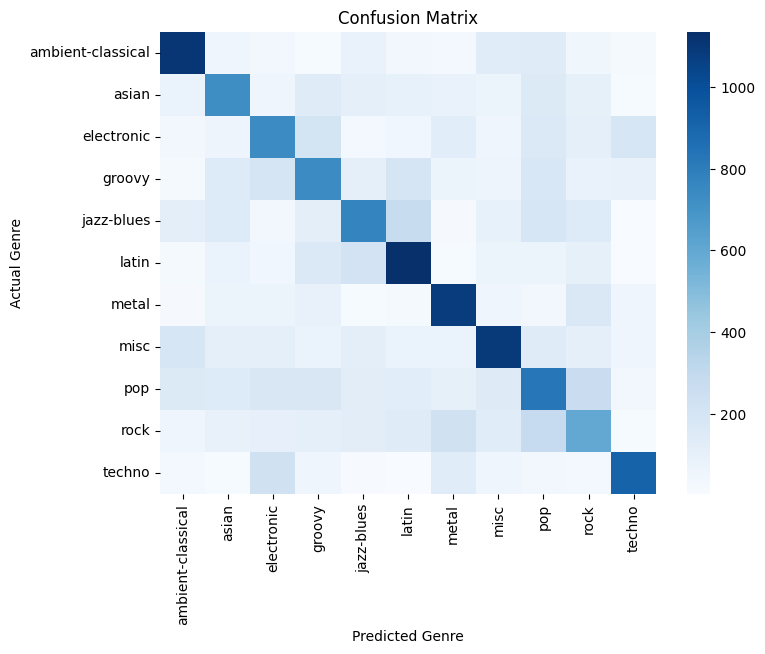

In [ ]:
# Use the best model to predict on the test set
y_pred_prePCA = best_model_rf_prePCA.predict(X_test_prePCA)

# Find the accuracies and confusion matrix
rf_acc_prePCA = best_model_rf_prePCA.score(X_test_prePCA, y_test_prePCA)
rf_acc_prePCA_train = best_model_rf_prePCA.score(X_train_prePCA, y_train_prePCA)
rf_confusion_prePCA = confusion_matrix(y_test_prePCA, y_pred_prePCA)

print(f"Pre PCA random forest: train accuracy: {rf_acc_prePCA_train:.4f}; test accuracy: {rf_acc_prePCA:.4f}")
plot_confusion_matrix(rf_confusion_prePCA)

In [ ]:
# Hyperparameter search using the same parameter grid
grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=random_seed),
                             param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get model with best results
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_
print(f"Best hyperparameters: {best_params_rf}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best hyperparameters: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 90}


Post PCA random forest: train accuracy: 0.9682; test accuracy: 0.3970


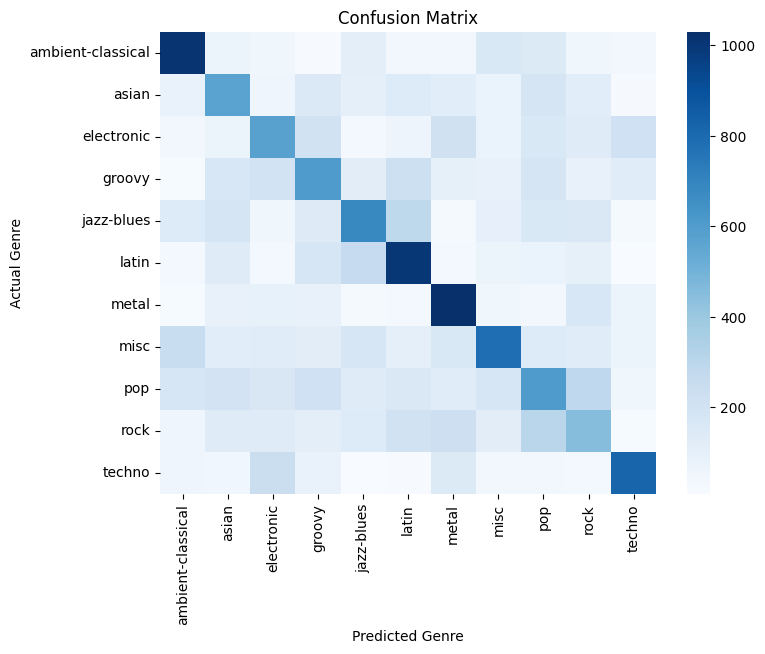

In [ ]:
# Use the best model to predict on the test set
y_pred = best_model_rf.predict(X_test)

# Find the accuracies and confusion matrix
rf_acc = best_model_rf.score(X_test, y_test)
rf_acc_train = best_model_rf.score(X_train, y_train)
rf_confusion = confusion_matrix(y_test, y_pred)

print(f"Post PCA random forest: train accuracy: {rf_acc_train:.4f}; test accuracy: {rf_acc:.4f}")
plot_confusion_matrix(rf_confusion)

Both random forest classifiers has a better performance than the logistic regression model, with the before PCA classifier achieving a test accuracy of 0.4742. It is able to better discern the more difficult genres logistic regression struggled with, such as asian, pop and rock.

Interestingly, the random forest classifier of data after PCA performed worse than before PCA. This might be due to the fact that a feature with high variance does not necessarily imply a feature with high predictive power. It could be the case where the intricacies are actually the features with the highest predictive power, but since they have a lower variance they are discarded by the PCA model.

### K-Nearest Neighbors

Lastly in our series of traditional models, we also try implementing a k-nearest neighbors (KNN) algorithm. One of the strengths of KNN is its simplicity and ease of implementation. It is a non-parametric and instance-based algorithm that can adapt to different data distributions, especially when there are local patterns or clusters within the data. This makes it suitable for this scenario, where songs in the same genre would tend to have some similar features.

However, KNN has some limitations. It can be computationally expensive, especially with large datasets, as it requires calculating distances between the query point and all other data points. The algorithm is also sensitive to irrelevant and redundant features. Additionally, KNN lacks interpretability, as it doesn't provide insights into the underlying relationships between features and genres.

In a KNN algorithm, determining the optimal value for the number of neighbors (K) is crucial and can impact the model's performance. To determine the optimal value of K, a hyperparameter search is performed by iterating through different K values and finding the model which produced the lowest error. Since this does not use a method with cross-validation, a separate validation set is split out from the training set at an 80-20 ratio.

Text(0.5, 1.0, 'Number of Neighbors vs Error of KNN ALgorithm')

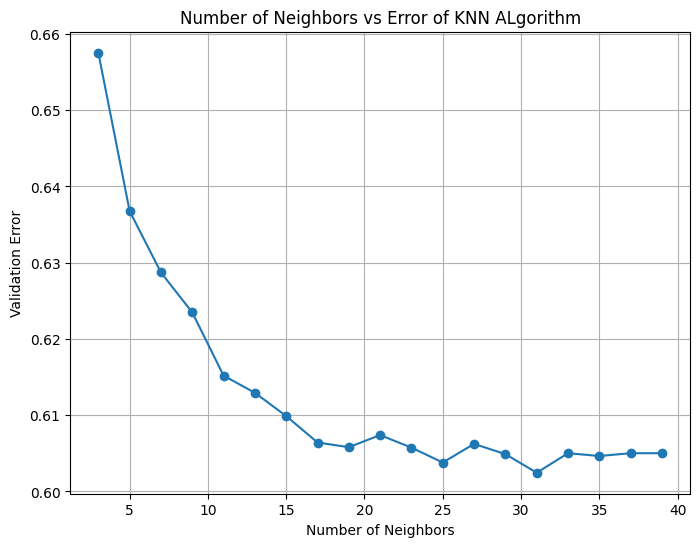

In [ ]:
# Split validation set from training set
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed, stratify=y_train)

num_neighbors = np.arange(3,41,2)
error_rate = []
for n in num_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_train, y_train_train)
    pred = knn.predict(X_train_val)
    error_rate.append(np.mean(pred!=y_train_val))

# Plot k vs validation error
plt.figure(figsize=(8,6))
plt.plot(num_neighbors, error_rate, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Validation Error')
plt.grid()
plt.title('Number of Neighbors vs Error of KNN ALgorithm')

From the plot above, the number of neighbors is is selected to be 31, which is where the lowest validation error is.

K-nearest neighbors: train accuracy: 0.4411; test accuracy: 0.3927


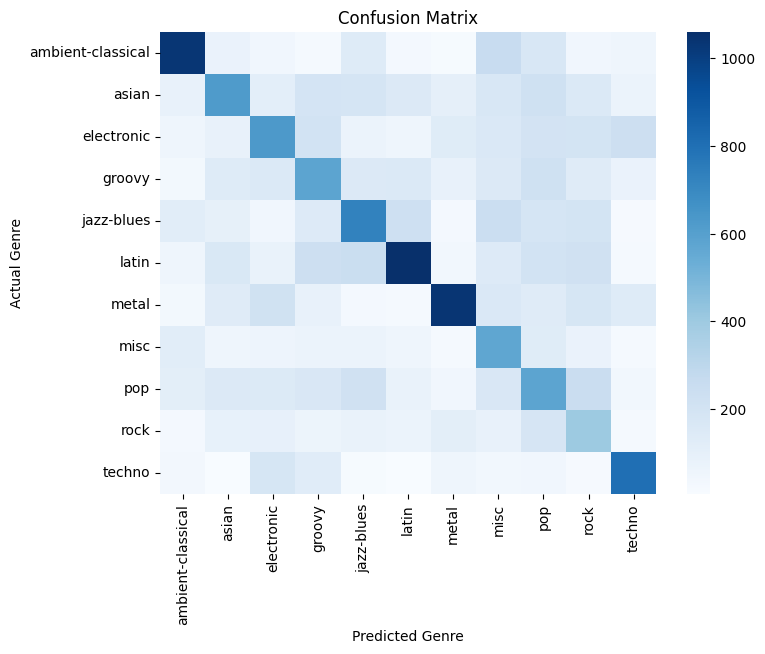

In [ ]:
best_k = 31

# Initialize model and fit it on the training set
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Use the model to predict on the test set
knn_pred = knn.predict(X_test)

# Find the accuracy
knn_acc = knn.score(X_test, y_test)
knn_acc_train = knn.score(X_train, y_train)

# Find the confusion matrix
knn_confusion = confusion_matrix(knn_pred, y_test)

print(f"K-nearest neighbors: train accuracy: {knn_acc_train:.4f}; test accuracy: {knn_acc:.4f}")
plot_confusion_matrix(knn_confusion)

In comparison to the previously evaluated models, KNN exhibits a relatively modest performance. The training accuracy of 0.4411 suggests that the model captures certain patterns in the training data, but this may not be sufficiently complex or nuanced, as evidenced by the test accuracy of 0.3927. The KNN model's performance falls between that of logistic regression and random forests, showing an improvement over logistic regression but not reaching the high accuracy levels achieved by the pre-PCA random forest. While KNN may capture local patterns well due to its proximity-based approach, it seems to struggle with generalization to unseen data in comparison to the more sophisticated random forest models.

## Advanced Models

We will now attempt to use some more advanced models to perform our prediction. The hope is that these methods may perform better than the simpler models despite reducing interpretability, perhaps capturing more complex relationships between features and the target.

### Gradient-Boosted Classifiers

Here we use a gradient-boosting method to fit a series of decision trees. Gradient-boosting relies on training an iteratively increasing number of weak classifiers in order to minimize the residual from the classifier composed of all previous classifiers. In a sense, it can be thought of as training a sequence of models where each model addresses the weaknesses of the last.

This is similar conceptually to the more general boosting technique, but gradient boosting utilizes the gradient of the loss function with respect to the previous classifier. While this method has a proven efficacy, it is also performance-intensive. Here instead we use a histogram-based gradient boosted classification tree, which runs significantly faster for datasets >= 10,000 entries. Our dataset meets these criteria:

In [ ]:
print(f"Number of samples in training set: {X_train.shape[0]}")
print(f"Number of samples in test set: {X_test.shape[0]}")

Number of samples in training set: 82036
Number of samples in test set: 20509


Now we can perform hyperparameter tuning using `GridSearchCV` and train the `HistGradientBoostingClassifier` according to the best hyperparameter selected. Similar to Random Forest, we also trained this model on data before and after PCA to see if there are any differences in performance.

In [ ]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'l2_regularization': [0, 0.1, 0.25],
    'max_depth': [10, 20, 50]
}

# Hyperparameter search
grid_search_hist_gb_prePCA = GridSearchCV(HistGradientBoostingClassifier(random_state=random_seed),
                             param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search_hist_gb_prePCA.fit(X_train_prePCA, y_train_prePCA)

# Get model with best results
best_params_hist_gb_prePCA = grid_search_hist_gb_prePCA.best_params_
best_model_hist_gb_prePCA = grid_search_hist_gb_prePCA.best_estimator_
print(f"Best hyperparameters: {best_params_hist_gb_prePCA}")

Best hyperparameters: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 10}


Pre PCA gradient boosted classifier: train accuracy: 0.5895; test accuracy: 0.4914


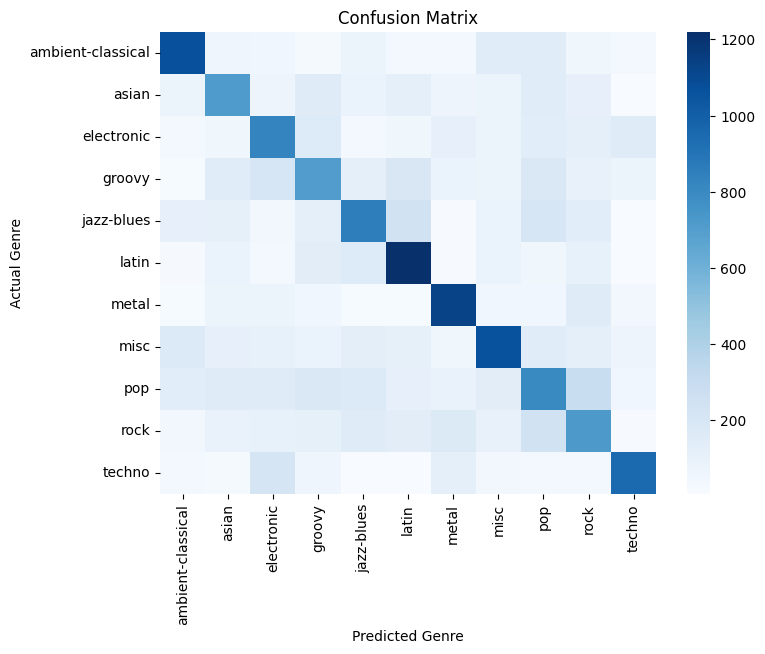

In [ ]:
# Use the best model to predict on the test set
y_pred = best_model_hist_gb_prePCA.predict(X_test_prePCA)

# Find the accuracies and confusion matrix
hist_gb_acc_prePCA = best_model_hist_gb_prePCA.score(X_test_prePCA, y_test_prePCA)
hist_gb_acc_train_prePCA = best_model_hist_gb_prePCA.score(X_train_prePCA, y_train_prePCA)
hist_gb_confusion_prePCA = confusion_matrix(y_test_prePCA, y_pred)

print(f"Pre PCA gradient boosted classifier: train accuracy: {hist_gb_acc_train_prePCA:.4f}; test accuracy: {hist_gb_acc_prePCA:.4f}")
plot_confusion_matrix(hist_gb_confusion_prePCA)

In [ ]:
# Hyperparameter search
grid_search_hist_gb= GridSearchCV(HistGradientBoostingClassifier(random_state=random_seed),
                             param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search_hist_gb.fit(X_train, y_train)

# Get model with best results
best_params_hist_gb = grid_search_hist_gb.best_params_
best_model_hist_gb = grid_search_hist_gb.best_estimator_
print(f"Best hyperparameters: {best_params_hist_gb}")

Best hyperparameters: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 20}


Post PCA gradient boosted classifier: train accuracy: 0.5109; test accuracy: 0.3935


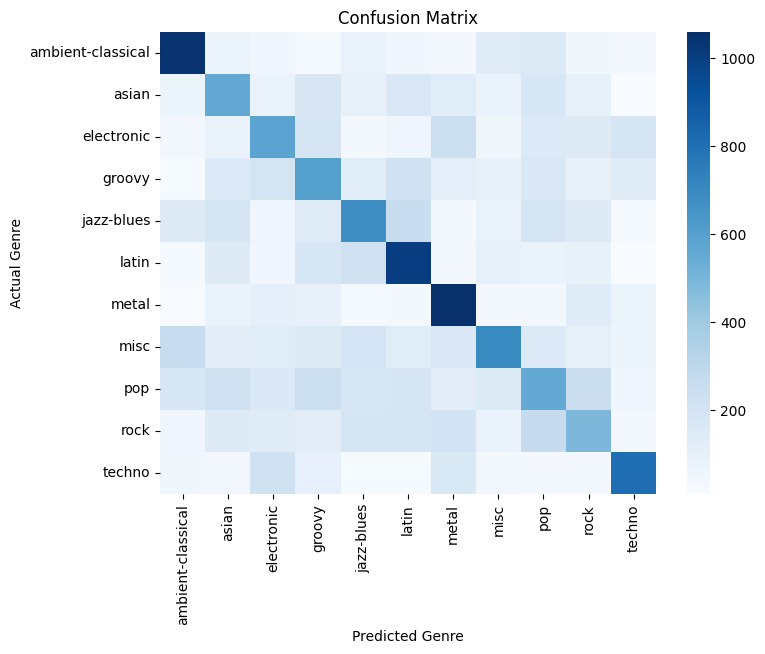

In [ ]:
# Use the best model to predict on the test set
y_pred = best_model_hist_gb.predict(X_test)

# Find the accuracies and confusion matrix
hist_gb_acc = best_model_hist_gb.score(X_test, y_test)
hist_gb_acc_train = best_model_hist_gb.score(X_train, y_train)
hist_gb_confusion = confusion_matrix(y_test, y_pred)

print(f"Post PCA gradient boosted classifier: train accuracy: {hist_gb_acc_train:.4f}; test accuracy: {hist_gb_acc:.4f}")
plot_confusion_matrix(hist_gb_confusion)

The performance of gradient boosted classification trees are similar to those of random forest. The highest accuracy achieved is 0.4914, slightly higher than the random forest accuracy of 0.4742. Just like for random forest, the model fitted with pre PCA data performed better than the model fitted with post PCA data.

### Deep Neural Network



Before we continue toward using a deep neural network model, let's step back a bit and reflect. The previous models we have run demonstrate an accuracy score significantly better than random chance -- considering our coarse genre labels (11 possible values), random chance would get the correct answer 9% of the time. Our other classifiers generally seem to score in the ballpark of 30 to 40% accuracy, with the highest at 49.14%.

However, an accuracy of 49.14% still gives us significant room for improvement.

If we suspect there is some nonlinear relationship between the features we are using and the genre, a deep neural network is a promising candidate -- a model with more complexity that could capture highly complex or abstract relationships.

Employing a deep neural network (DNN) offers both advantages and challenges. The strength of DNNs lies in their ability to automatically learn intricate and non-linear patterns from complex data, capturing intricate relationships between the features and genres. They are capable of feature representation learning, allowing the model to discern hierarchical features that might be crucial for genre classification.

However, the black-box nature of these models can make it challenging to interpret and understand how specific features contribute to predictions. Additionally, DNNs can be prone to overfitting, and proper tuning of hyperparameters and consideration of the model architecture are crucial yet resource heavy for achieving optimal performance with deep neural networks.


First we set up GPU capabilities if they're available:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.1.0+cu118
cpu


Then we need to construct the data loaders for our train and test sets. Since we have established already that valuable information is lost during PCA, we use the pre PCA dataset for this model:

In [ ]:
# Define dataset class
class SpotifyDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.from_numpy(inputs).type(torch.FloatTensor)
        self.labels = torch.from_numpy(labels).type(torch.LongTensor)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.inputs[idx], self.labels[idx])
        return sample

# Load the data into datasets and dataloaders
# train_dataset = SpotifyDataset(X_train, y_train)
# test_dataset = SpotifyDataset(X_test, y_test)
train_dataset = SpotifyDataset(X_train_prePCA, y_train_prePCA)
test_dataset = SpotifyDataset(X_test_prePCA, y_test_prePCA)
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

Now we can define the neural network. The network is constructed using linear layers with a ReLU activation function. A dropout layer is also included between linear layers to provide regularisation and prevent overfitting. It also takes the number of hidden layers as a hyperparameter, which will be tuned to find the optimal value.

In [ ]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, hidden_layer_depth):
        super().__init__()

        # input_size = PCA_count # Number of principal components we are using
        input_size = 18
        hidden_size = 128
        output_size = len(encoded_genre_labels)

        if hidden_layer_depth == 0: # If no hidden layers, go directly to output dimensionality
            self.base_layer = nn.Linear(input_size, output_size, bias=True)
        else:
            self.base_layer = nn.Linear(input_size, hidden_size, bias=True)

        sequence = []
        for i in range(hidden_layer_depth):
            if i == hidden_layer_depth-1: # End of hidden layers
                sequence.append(nn.ReLU())
                sequence.append(nn.Dropout(0.2))
                sequence.append(nn.Linear(hidden_size, output_size, bias=True))
            else: # Intermediate fully-connected layers
                sequence.append(nn.ReLU())
                sequence.append(nn.Dropout(0.2))
                sequence.append(nn.Linear(hidden_size, hidden_size, bias=True))

        # Unpack sequence to form hidden layers
        self.hidden = nn.Sequential(*sequence)

    def forward(self, x):
        x = self.base_layer(x)
        outputs = self.hidden(x)
        # Normally we would put a softmax here, but we will use Cross-Entropy loss during training
        # outputs = F.log_softmax(outputs,1)
        return outputs

Before we perform our tuning, we define the parameter grid for hyperparameter tuning. This grid defines the combinations of hyperparameter values that will be explored during the tuning process. Here, we elect to try combinations of beta values, learning rate, and network layer depth.

In [ ]:
beta1_values = [0.9, 0.99]
beta2_values = [0.999, 0.99]
betas = [(x, y) for x, y in itertools.product(beta1_values, beta2_values)]

# Construct parameter grid
param_grid = {'beta': betas, 'learning_rate': [0.1, 0.01, 0.001], 'num_ff': [1, 3, 5]}
pgrid = ParameterGrid(param_grid)

num_epochs = 10

Here we define the training loop, using the Adam optimizer and the parameters of our DNN. We also define a function that tests the model.

In [ ]:
def runTrainingLoop(beta_tuple, learning_rate, ff_layers, epochs):
    dnn_tuned = DeepNeuralNetwork(hidden_layer_depth=ff_layers).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(dnn_tuned.parameters(), lr=learning_rate, betas=beta_tuple)

    # Train the network
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for _, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # Reset the optimizer tensor gradient every mini-batch
            optimizer.zero_grad()
            # Feed the network train data
            outputs = dnn_tuned(inputs)
            # Get the prediction using argmax
            pred_labels = outputs.argmax(dim=1)
            # Find average loss for one mini-batch of inputs
            loss = criterion(outputs, labels)
            # Perform a back propagation
            loss.backward()
            # Update the weight using gradients from back propagation
            optimizer.step()
            # Get loss and add to accumulated loss for each epoch
            running_loss += loss.item()
            # Get number of correct prediction and increment the number of correct and total predictions
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)

        # Print some useful debug info if enabled
        print_debug = False
        if print_debug:
            print(f"Inputs type: {type(inputs)}, shape: {inputs.shape}")
            print(f"Outputs type: {type(outputs)}, shape: {outputs.shape}")
            print(f"Pred_labels: {pred_labels}, type: {type(pred_labels)} shape: {pred_labels.shape}")
            print(f"Labels: {labels}, type: {type(labels)} shape: {labels.shape}")
            print(f"Correct: {correct}, type: {type(correct)}")
            print(f"Epoch {epoch+1}: accuracy = {correct/total}, loss = {running_loss/len(train_loader)}")
    return dnn_tuned

def testModel(model):
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # labels = labels.type(torch.LongTensor) # Cast to Float
            inputs, labels = inputs.to(device), labels.to(device)
            # Get the outputs of the model
            outputs = model(inputs)
            # Get the predictions using argmax
            pred_labels = outputs.argmax(dim=1)
            # Get number of correct prediction and increment the number of correct and total predictions
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)

    # Calculate test accuracy
    test_acc_tuned = correct / total
    return test_acc_tuned


perf_map = {}
# Iterate through each hyperparameter combination
for params in pgrid:
    beta_tuple = params['beta']
    learning_rate = params['learning_rate']
    fc_layers = params['num_ff']
    # Train model with selected hyperparameter combination
    trained_model = runTrainingLoop(beta_tuple, learning_rate, fc_layers, num_epochs)
    # Test the accuracy of model
    test_acc = testModel(trained_model)
    perf_map[(beta_tuple, learning_rate, fc_layers)] = test_acc
    # Print the hyperparameter and corresponding accuracy
    print(f"Params: {params}, test accuracy: {test_acc}")

# Find the model with highest accuracy and find its hyperparameters
best_params = None
highest_acc = 0
for key in perf_map.keys():
    if perf_map[key] > highest_acc:
        highest_acc = perf_map[key]
        best_params = key

Params: {'beta': (0.9, 0.999), 'learning_rate': 0.1, 'num_ff': 1}, test accuracy: 0.21414988541615876
Params: {'beta': (0.9, 0.999), 'learning_rate': 0.1, 'num_ff': 3}, test accuracy: 0.09230094105027062
Params: {'beta': (0.9, 0.999), 'learning_rate': 0.1, 'num_ff': 5}, test accuracy: 0.09230094105027062
Params: {'beta': (0.9, 0.999), 'learning_rate': 0.01, 'num_ff': 1}, test accuracy: 0.38197864352235605
Params: {'beta': (0.9, 0.999), 'learning_rate': 0.01, 'num_ff': 3}, test accuracy: 0.34916378175435175
Params: {'beta': (0.9, 0.999), 'learning_rate': 0.01, 'num_ff': 5}, test accuracy: 0.2661758252474523
Params: {'beta': (0.9, 0.999), 'learning_rate': 0.001, 'num_ff': 1}, test accuracy: 0.39719147691257495
Params: {'beta': (0.9, 0.999), 'learning_rate': 0.001, 'num_ff': 3}, test accuracy: 0.4195231361841143
Params: {'beta': (0.9, 0.999), 'learning_rate': 0.001, 'num_ff': 5}, test accuracy: 0.41337949193037204
Params: {'beta': (0.9, 0.99), 'learning_rate': 0.1, 'num_ff': 1}, test accu

In [ ]:
print(f"Best params are (beta, learning rate, network depth): {best_params}")
print(f"These parameters yielded an accuracy of {round(highest_acc * 100, 2)}%")

Best params are (beta, learning rate, network depth): ((0.99, 0.99), 0.001, 3)
These parameters yielded an accuracy of 42.45%


# Project Summary


## Conclusions from Modeling & Analysis

Considering the results of each model, we are not totally satisfied with the performance, which is on average within the 30-40% range. Even the relatively highly complex deep learning-based model was unable to get past the mid-40% range.

 However, again considering the number of classes to predict (11), the conceptual difficulty of the problem starting with the abstract yet intertwined nature of genre, and the nature of the musical features, we think this is actually fairly decent. Certainly, we would expect around 9% accuracy if the genre was determined by random chance, so 49% is significantly better. The problem does also appear to be easier for some genres than others, considering the confusion matrices plotted for each type of model (with metal and techno routinely showing up with the most accurate predictions).

 There are essentially three possibilities given these results that would explain why we were unable to obtain a highly accurate model. The first is that our modeling is erroneous in some way. Since we were very thorough with checking both the meaning and syntax of our code and our models, we optimistically believe that instead some mixture of the following two possibilities is responsible:
  1. Either the given features do not fully explain genre variations, or
  2. The models and hyperparameters we selected are not enough to capture the true relationship.

It's important to note that both of these can be true in varying proportion. The fact that some features do *not* adequately explain our target variable is a valid (and perhaps even useful) finding in itself. However, the possibility is open that a more complex model could find a relationship between the two.

## Findings and Business Value

Essentially what we have found is that the given features are not capable of explaining more than half of the variation in coarse genres of songs -- at least with the types of models we have attempted.

This implies that these features by themselves are useful only for very loose genre classification. This may warrant investment of effort into additional methods of feature extraction from tracks. In our future directions, we will address a few ideas for this.

However, we should also acknowledge that the results we have obtained suggest that the features really do explain some of the variation in genre. This implies that we may be able to use these features to provide a broader or different type of classification, for example to classify the appropriateness of tracks for a given event or situation. Such an application would require additional labels, however, and so would not be possible with the current dataset as-is.

While our models do not quite reach the level of applicability for automatic labeling of songs on Spotify, we believe that our analyses still act as proof-of-concept for the idea that we can use musical features to predict genre.

The business value of genre prediction may not be clearly obvious at first, but we believe that the music industry would have interest in such a technology primarily from the perspective of a nice user experience. For instance, we could take a user’s favorite songs, take their features (either individually or aggregated, such as through averaging), and suggest to the user genres they might be interested in browsing.

Also, if the genre of a track is not directly labeled at the time it is being played, such as during a livestream of a musical show or concert, the streaming service could use this type of genre prediction to provide advertisements that are more relevant to the show, and therefore probably more relevant to its listeners.

Genre prediction could even be used in music education or cultural preservation. In education, students could play a song and see what it would be classified as. In cultural preservation, we can imagine perhaps a niche subgenre that may not be widely recognized. If a genre-prediction model can predict these niche subgenres,  then those subcultures can be labeled and preserved when they might otherwise be lost.


## Challenges and Limitations

One major challenge faced by our project is the nature of the features and the problem. Classifying points cleanly into genres is by its nature a difficult problem due to the relative subjectivity and abstract nature of how humans classify songs by genre. We attempted to account for this by using increasingly complex models, but ultimately achieved similar low-to-moderate accuracy among all models, even when grouping songs much more loosely.

Additionally, the features we used in our analysis are of fairly low dimension. While this aids in the computational speed of training and testing our models, we also expect that these do not capture all musical information that is relevant to the genre-classification problem. When looking at most features (such as via our 2D visualizer app enabled by Streamlit!), almost every genre has a wide spread of values along almost every feature dimension.

For example, we notice that metal music often has low acousticness, and this is likely a result of the instruments used in metal influencing this variable, but given the spread it seems unlikely that this is fully encompassed in the acousticness feature (or instrumentalness, for that matter). With a few exceptions, the quantification of musical features is an open (and somewhat subjective) problem in its own right, but we believe that additional musical features exist that could help predict genre.

Our models are also not capable of predicting multiple genres for the same song. Such an approach would be advantageous for genre classification in cases where the classification is ambiguous or truly does belong to one or more genres in one way or another. This type of classification is known as multilabel classification, where the prediction can output multiple labels. However, such a method complicates analysis and has not been done here.


## Potential Future Directions


Here we consider a few avenues for extension of the work presented here.



1.   Additional music feature extraction. As discussed, additional musical features may be helpful in classifying genre. These musical features could be extracted using classical programmatic methods (such as, say, splitting the audio waveform into component waves via Fourier transform and finding the relative amplitude of waves of differing frequencies). As these features would be extracted using a known process, we could easily assign a specific meaning to them, analogous to how the original dataset authors assigned the meaning “instrumentalness” to the associated feature.
Other methods could themselves use machine learning. For example, an undercomplete autoencoder neural network could be used to essentially compress the song into a relatively small amount of numerical features at the “thinnest” part of the network.  These features could then be used as features in future genre classification tasks, although their interpretabilty would be much more difficult. Likewise, we could use a 1D convolution on the audio signal to learn time-dependent features that help predict genre, and use some aggregation of those features for similar purposes.

2.   Multilabel classification. Our analysis was based on the idea that we would predict a single genre for a track. This is reflected in our code when we take the argmax of the output class probabilities. However, as discussed previously, a song can lie within multiple genres. It would make sense for the model to output, for each track, a set of multiple binary predictions, each corresponding to one genre, where more than one genre can be predicted to be the true genre. This would require adaptation of our loss function – we would need to compare the true genre, which could either be single- or multi-label itself, with the set of predicted genres and we would need a means of producing a loss value from this comparison. The simplest would be to check if the set of true genres directly matches the set of predicted genres, but ideally we would also award “partial credit” for partially-correct answers.
Another approach to this would be to take some number N of predicted output classes with the highest probabilities and compare the true genre against those. How much the loss changes in response to the placement of the true genre in the predicted set is something we could tune. One could imagine a simple case where the model predicts 3 genres in order of probability, such as ('pop', 'rock', 'metal'). In this case, the lower the distance of the true genre to the first element, the lower the loss.

3.   Join with user-specific data to produce findings that are relevant to marketing. If we have an additional dataset of the musical preferences of users, or of their activities on certain musical tracks, we could join this with our current dataset. Such a join would potentially allow us to determine if the existing musical features can help predict whether a song is liked by a particular user, or we could use aggregate user behaviors on songs to aid in prediction of genre. For instance, it may be the case that some types of song get skipped more often. We believe that such an extension of the dataset could enrich not only the task we set out to do in this project, but also that our musical features could potentially be helpful to other tasks which would utilize those other datasets. For example, the musical features of songs a user routinely skips, likes, dislikes or listens to completely may help in classifying users according to some other label.
